In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
train_dir = "data/train"
test_dir  = "data/test"

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [4]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [8]:
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [9]:
model = models.resnet50(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/mac/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 25.1MB/s]


In [10]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()
    return model


Epoch 0/9
----------
train Loss: 2.5830 Acc: 0.2812
test Loss: 2.3318 Acc: 0.4407

Epoch 1/9
----------
train Loss: 1.7626 Acc: 0.4829
test Loss: 2.1920 Acc: 0.4237

Epoch 2/9
----------
train Loss: 1.5487 Acc: 0.5420
test Loss: 2.1125 Acc: 0.4788

Epoch 3/9
----------
train Loss: 1.3760 Acc: 0.5860
test Loss: 1.9661 Acc: 0.4831

Epoch 4/9
----------
train Loss: 1.2900 Acc: 0.6096
test Loss: 1.9906 Acc: 0.4788

Epoch 5/9
----------
train Loss: 1.1988 Acc: 0.6366
test Loss: 2.1455 Acc: 0.5127

Epoch 6/9
----------
train Loss: 1.1976 Acc: 0.6259
test Loss: 2.2001 Acc: 0.4958

Epoch 7/9
----------
train Loss: 1.1527 Acc: 0.6413
test Loss: 2.1004 Acc: 0.4831

Epoch 8/9
----------
train Loss: 1.1068 Acc: 0.6455
test Loss: 2.0570 Acc: 0.4915

Epoch 9/9
----------
train Loss: 1.0602 Acc: 0.6584
test Loss: 1.9377 Acc: 0.4873



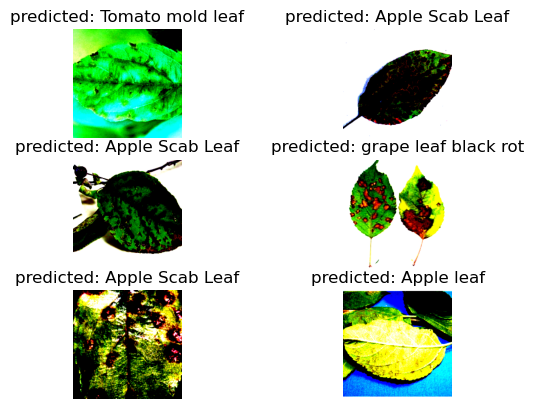

In [11]:
model = train_model(model, criterion, optimizer, num_epochs=10)

# Save the trained model
torch.save(model.state_dict(), 'plant_disease_model.pth')

# Function to visualize some predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Visualize the model predictions
visualize_model(model)
plt.show()
